# Base model development

Create an oracle model that set the base line for next steps

In [1]:
%load_ext autoreload
%autoreload 2

In [72]:
from model_class import CatBoostXT_BAG

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [165]:
import shap
import matplotlib.pyplot as plt
import pickle
import json

In [115]:
import optuna

## LOAD DATA

In [166]:
data_dir = r'E:\Project\Dissertation'

In [5]:
list_key = ['SK_ID_CURR']
label_col = 'TARGET'

In [6]:
df_features = pd.read_parquet(rf'{data_dir}\data\processed\final_df.parquet').reset_index(drop=True)
df_features = df_features.replace({None: np.nan})

df_app = pd.read_csv(rf'{data_dir}\home-credit-default-risk\application_train.csv').reset_index(drop=True)

In [272]:
df = df_app.merge(df_features, on='SK_ID_CURR', how='left')

In [273]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bb_w24_status_2_share__sum,bb_w24_status_3_share__mean,bb_w24_status_3_share__max,bb_w24_status_3_share__sum,bb_w24_status_4_share__mean,bb_w24_status_4_share__max,bb_w24_status_4_share__sum,bb_w24_status_5_share__mean,bb_w24_status_5_share__max,bb_w24_status_5_share__sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0


In [275]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=1, stratify=df[label_col])

In [276]:
# combine X and y train test to store to parquet
df_train['flag_train_val'] = 'train'
df_test['flag_train_val'] = 'valid'

In [287]:
pd.concat([df_train, df_test], axis=0).to_parquet(rf'{data_dir}\data\processed\master_data_flagged_trainval.parquet', index=False)

In [6]:
df = pd.read_parquet(rf'{data_dir}\data\processed\master_data_flagged_trainval.parquet')

In [7]:
# separate features, target
list_features = [col for col in df.columns if col not in ['TARGET','SK_ID_CURR','flag_train_val']]
# features that starts with EXT_
list_ext_features = [col for col in df.columns if col.startswith('EXT_')]
# list ethical features
list_ethical_features = [col for col in df.columns if 'GENDER' in col]
# list categorical features
list_cat_features = df.select_dtypes(include=['object','category']).columns.tolist()
list_cat_features = list(set(list_cat_features)-set(list_ethical_features)-set(['flag_train_val']))

In [163]:
dict_cols = {
    'list_key': list_key,
    'label_col': label_col,
    'list_features': list_features,
    'list_cat_features': list_cat_features,
    'list_ext_features': list_ext_features,
    'list_ethical_features': list_ethical_features
}

In [168]:
with open(rf'{data_dir}\models\dict_cols.json', 'w') as f:
    json.dump(dict_cols, f, indent=4)

In [8]:
list_ext_features

['EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_MIN',
 'EXT_MAX',
 'EXT_MEAN',
 'EXT_STD',
 'EXT_VAR',
 'EXT_SPAN']

In [9]:
list_ethical_features

['CODE_GENDER']

In [10]:
list_cat_features

['NAME_EDUCATION_TYPE',
 'w90_last_loan_type',
 'NAME_INCOME_TYPE',
 'w30_last_loan_type',
 'w360_last_loan_type',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'OCCUPATION_TYPE',
 'NAME_TYPE_SUITE',
 'EMERGENCYSTATE_MODE',
 'NAME_HOUSING_TYPE',
 'w720_last_loan_type',
 'FLAG_OWN_CAR',
 'WALLSMATERIAL_MODE',
 'FLAG_OWN_REALTY',
 'FONDKAPREMONT_MODE',
 'w180_last_loan_type',
 'WEEKDAY_APPR_PROCESS_START',
 'NAME_FAMILY_STATUS',
 'NAME_CONTRACT_TYPE']

In [11]:
df[list_cat_features] = df[list_cat_features].fillna('Missing')

In [12]:
df_train = df.loc[df['flag_train_val']== 'train'] 
df_test = df.loc[df['flag_train_val']== 'valid']

In [13]:
long_list = list(set(list_features)-set(list_ext_features)-set(list_ethical_features))
len(long_list)

576

In [14]:
# split train test
X_train = df_train[long_list]
X_test = df_test[long_list]
y_train = df_train[label_col]
y_test =  df_test[label_col]

In [15]:
y_train

0         0
1         0
2         0
3         0
4         0
         ..
230628    1
230629    0
230630    0
230631    0
230632    1
Name: TARGET, Length: 230633, dtype: int64

In [16]:
# summary of train test split data, count of target variable
print('Train set shape:', X_train.shape, y_train.shape)
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())

print('Test set shape:', X_test.shape, y_test.shape)
print(y_test.value_counts(normalize=True))
print(y_test.value_counts())

Train set shape: (230633, 576) (230633,)
TARGET
0    0.91927
1    0.08073
Name: proportion, dtype: float64
TARGET
0    212014
1     18619
Name: count, dtype: int64
Test set shape: (76878, 576) (76878,)
TARGET
0    0.919275
1    0.080725
Name: proportion, dtype: float64
TARGET
0    70672
1     6206
Name: count, dtype: int64


## Model Round 0

#### Tuning

In [ ]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.INFO)

In [79]:
base_model = CatBoostXT_BAG(
    num_bag_folds=5,
    num_bag_repeats=1,
    random_state=1,
    cat_features=list_cat_features
)

In [100]:
base_model.params = {
    'iterations': 1000,
    'learning_rate': 0.07,
    'depth': 5,
    'l2_leaf_reg': 50,
    'border_count': 128,
    'auto_class_weights': 'SqrtBalanced',
    'early_stopping_rounds': None,
    'od_type': 'IncToDec',
    'od_wait': 200,
    'od_pval': 0.01,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bernoulli',
    'loss_function': 'Logloss', 
    'eval_metric': 'Logloss',
    'task_type':'GPU',
    'devices':'0',
}

In [101]:
base_model.fit(X_train, y_train)

In [102]:
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [103]:
base_model.evaluate(X_train,y_train)

{'ROC_AUC': 0.7625887427943789, 'PR_AUC': 0.25925049714873905}

In [104]:
base_model.evaluate(X_test,y_test)

{'ROC_AUC': 0.7445511647641232, 'PR_AUC': 0.22695016304073454}

In [106]:
2*roc_auc_score(y_train,base_model.predict_proba(X_train)[:, 1]) - 1

0.5251774855887579

In [116]:
2*roc_auc_score(y_test,base_model.predict_proba(X_test)[:, 1]) - 1

0.4891023295282464

In [114]:
# dump base_model to pickle
with open(rf'{data_dir}\models\oracle_model_catboostxt_bag.pkl', 'wb') as f:
    pickle.dump(base_model, f)

In [108]:
# load pickle
with open(rf'{data_dir}\models\oracle_model_catboostxt_bag.pkl', 'rb') as f:
    base_model = pickle.load(f)

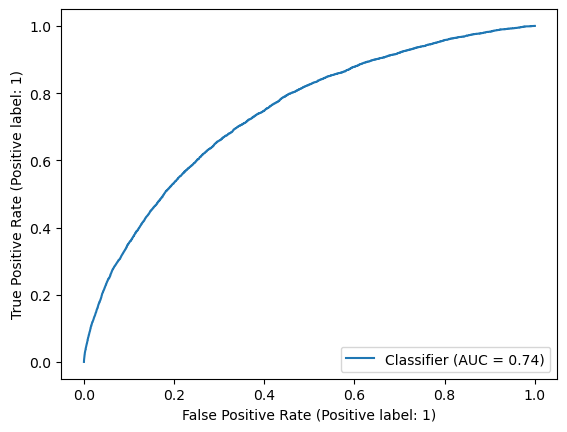

In [90]:
# Draw ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, base_model.predict_proba(X_test)[:, 1])

In [111]:
len(base_model.models)

5

In [107]:
base_model_feature_importance = base_model.get_average_shap_feature_importance(X_train)

In [108]:
base_model.feature_importances_shap_

,feature,importance
0,ANNUITY_TO_CREDIT,0.153741
1,GOODS_TO_CREDIT,0.139030
2,NAME_EDUCATION_TYPE,0.111187
3,OCCUPATION_TYPE,0.105804
4,DAYS_BIRTH,0.090992
...,...,...
571,FLAG_DOCUMENT_4,0.000000
572,bb_w24_share_status_gt4__max,0.000000
573,w90_share_overdue_gt90,0.000000
574,w30_debt_concentration_active,0.000000


In [109]:
# Draw shap summary plot from the base_model get_average_shap_values
base_model.get_feature_importance(X_train)


,feature,importance
0,ANNUITY_TO_CREDIT,12.785733
1,GOODS_TO_CREDIT,5.044007
2,DAYS_BIRTH,4.218902
3,NAME_EDUCATION_TYPE,3.523659
4,OCCUPATION_TYPE,2.890750
...,...,...
571,FLAG_DOCUMENT_4,0.000000
572,bb_w24_share_status_gt4__max,0.000000
573,w90_share_overdue_gt90,0.000000
574,w30_debt_concentration_active,0.000000


In [110]:
base_model.feature_importances_

,feature,importance
0,ANNUITY_TO_CREDIT,12.785733
1,GOODS_TO_CREDIT,5.044007
2,DAYS_BIRTH,4.218902
3,NAME_EDUCATION_TYPE,3.523659
4,OCCUPATION_TYPE,2.890750
...,...,...
571,FLAG_DOCUMENT_4,0.000000
572,bb_w24_share_status_gt4__max,0.000000
573,w90_share_overdue_gt90,0.000000
574,w30_debt_concentration_active,0.000000


In [36]:
X_test.columns[1]

'bb_w3_months_count__mean'

In [111]:
base_model.get_average_feature_interaction_score(X_train)

,Feature_1,Feature_2,Score
0,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,0.653967
1,FONDKAPREMONT_MODE,NAME_EDUCATION_TYPE,0.593005
2,ANNUITY_TO_CREDIT,AMT_GOODS_PRICE,0.477355
3,WEEKDAY_APPR_PROCESS_START,WALLSMATERIAL_MODE,0.475873
4,bb_w24_status_3_share__mean,FONDKAPREMONT_MODE,0.460777
...,...,...,...
2622,w720_laddering_share,AMT_ANNUITY,0.000093
2623,DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE,0.000072
2624,w30_annuity_over_total_debt,NAME_HOUSING_TYPE,0.000064
2625,REQ_YEAR_ONLY,BASEMENTAREA_MEDI,0.000051


In [112]:
base_model.feature_interaction_

,Feature_1,Feature_2,Score
0,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,0.653967
1,FONDKAPREMONT_MODE,NAME_EDUCATION_TYPE,0.593005
2,ANNUITY_TO_CREDIT,AMT_GOODS_PRICE,0.477355
3,WEEKDAY_APPR_PROCESS_START,WALLSMATERIAL_MODE,0.475873
4,bb_w24_status_3_share__mean,FONDKAPREMONT_MODE,0.460777
...,...,...,...
2622,w720_laddering_share,AMT_ANNUITY,0.000093
2623,DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE,0.000072
2624,w30_annuity_over_total_debt,NAME_HOUSING_TYPE,0.000064
2625,REQ_YEAR_ONLY,BASEMENTAREA_MEDI,0.000051


In [44]:
base_model_feature_importance.loc[base_model_feature_importance['importance']>0].nunique()

feature       487
importance    487
dtype: int64

In [26]:
list_features_top200 = base_model_feature_importance['feature'].tolist()[:200]

In [112]:
X_train['FLAG_OWN_CAR'].value_counts()

FLAG_OWN_CAR
N    152206
Y     78427
Name: count, dtype: int64

In [76]:
X_train[['CREDIT_TO_INCOME']].describe()

,CREDIT_TO_INCOME
count,230633.000000
mean,3.961270
std,2.684589
min,0.004808
25%,2.022400
50%,3.274533
75%,5.166133
max,35.477778


In [89]:
base_model.used_features

['bb_w3_share_status_gt0__mean',
 'bb_w3_status_5_share__mean',
 'bb_w12_status_max__mean',
 'bb_w24_status_mean__mean',
 'bb_w6_status_0_share__sum',
 'bb_w6_status_max__max',
 'bb_w3_status_4_share__sum',
 'bb_w12_longest_streak_status_gt0__max',
 'w90_annuity_over_total_debt',
 'bb_w24_share_unknown__sum',
 'bb_w12_status_1_share__mean',
 'w30_high_util_card_any',
 'w180_debt_concentration_active',
 'w720_share_overdue_gt90',
 'bb_w6_status_4_share__mean',
 'bb_w12_status_mean__mean',
 'ENTRANCES_MODE',
 'NAME_INCOME_TYPE',
 'w720_expo_growth_abs',
 'w360_last_loan_debt',
 'ID_PUBLISH_YEARS_AGO',
 'w180_expo_concentration',
 'bb_w24_share_status_gt4__mean',
 'w90_avg_days_remaining',
 'w90_n_closed_loans',
 'w720_last_loan_debt',
 'bb_w24_status_0_share__sum',
 'bb_w6_status_5_share__sum',
 'bb_w24_longest_streak_status_gt0__sum',
 'bb_w6_months_since_last_status_gt0__sum',
 'bb_w24_share_status_gt4__sum',
 'w360_active_ratio',
 'FLAG_DOCUMENT_2',
 'w90_short_term_risk',
 'bb_w12_sh

In [98]:
X_test[X_test[base_model.cat_features].isnull().any(axis=1)]

,bb_w3_share_status_gt0__mean,bb_w3_status_5_share__mean,bb_w12_status_max__mean,bb_w24_status_mean__mean,bb_w6_status_0_share__sum,bb_w6_status_max__max,bb_w3_status_4_share__sum,bb_w12_longest_streak_status_gt0__max,w90_annuity_over_total_debt,bb_w24_share_unknown__sum,...,FLAG_DOCUMENT_15,FLOORSMAX_MODE,bb_w6_status_3_share__sum,bb_w24_status_max__sum,bb_w6_status_max__mean,w90_type_diversity_shannon,bb_w24_status_max__max,DEF_60_CNT_SOCIAL_CIRCLE,bb_w24_months_count__mean,bb_w24_share_status_gt3__max


In [90]:
base_model.cat_features

['OCCUPATION_TYPE',
 'w90_last_loan_type',
 'NAME_HOUSING_TYPE',
 'w360_last_loan_type',
 'NAME_FAMILY_STATUS',
 'NAME_EDUCATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'w30_last_loan_type',
 'HOUSETYPE_MODE',
 'w180_last_loan_type',
 'EMERGENCYSTATE_MODE',
 'FONDKAPREMONT_MODE',
 'NAME_TYPE_SUITE',
 'ORGANIZATION_TYPE',
 'FLAG_OWN_CAR',
 'WALLSMATERIAL_MODE',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_CONTRACT_TYPE',
 'w720_last_loan_type']

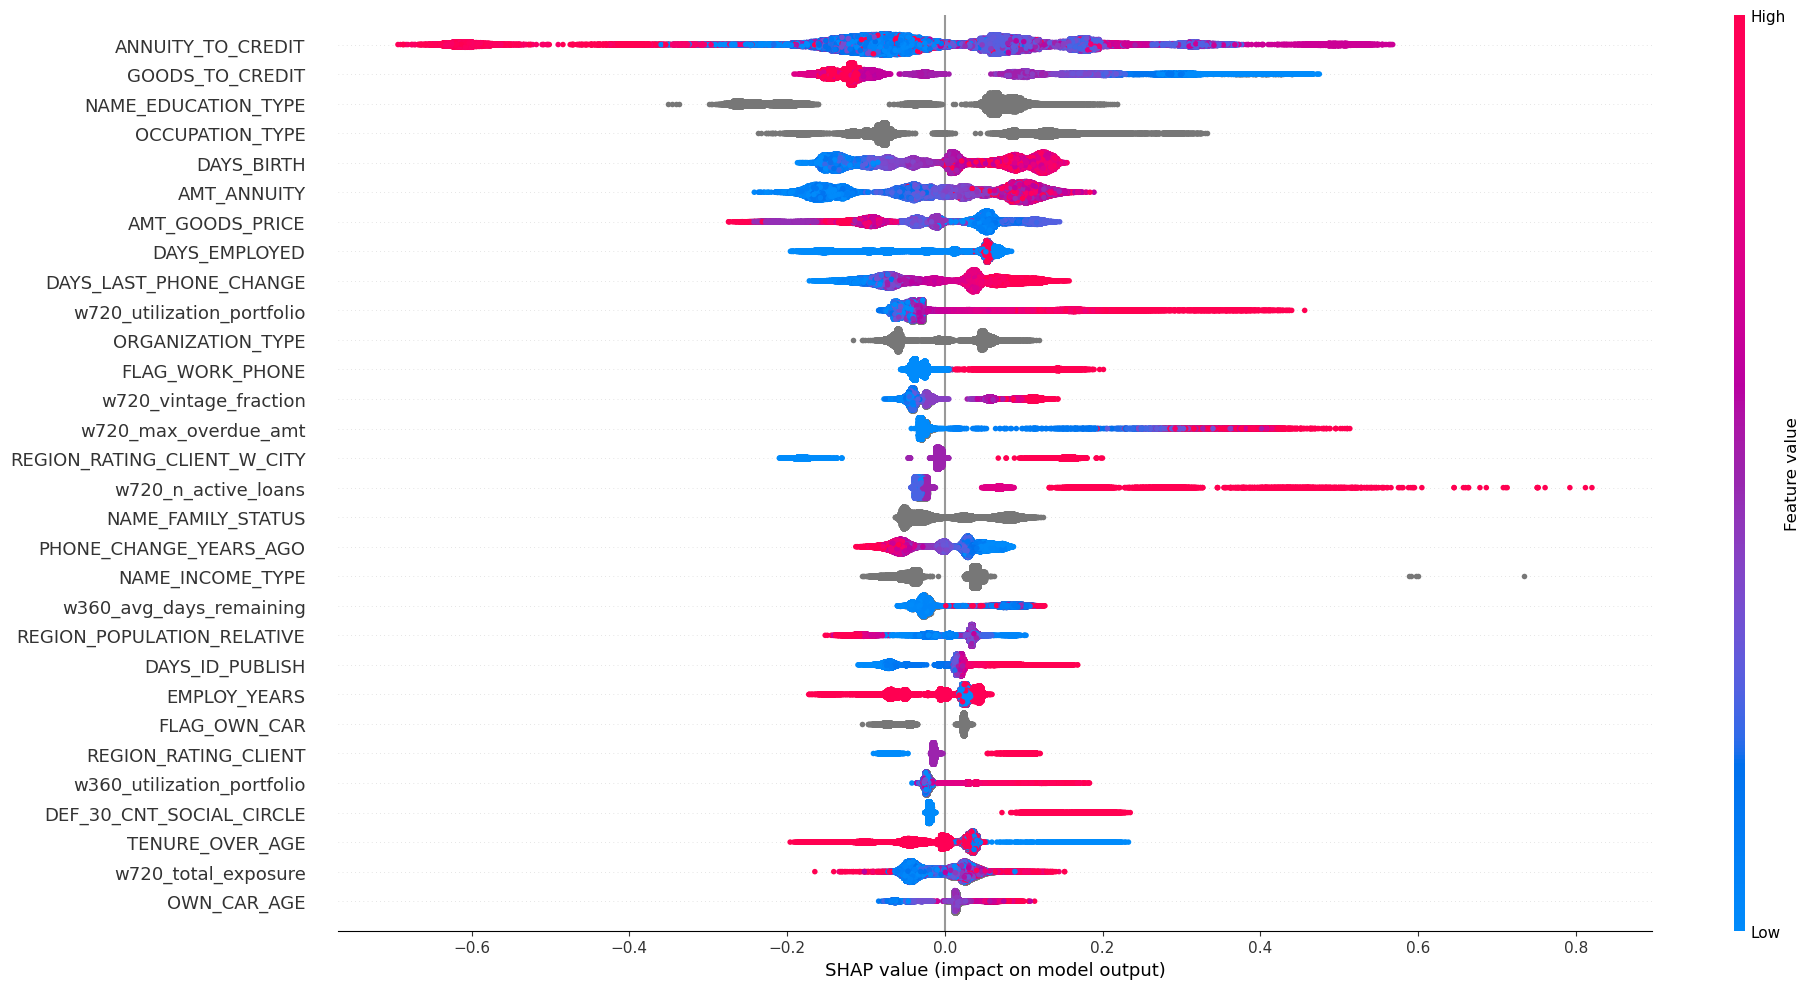

In [113]:
base_model.plot_shap_summary_plot(X_test, max_display=30, plot_size=(20,10))

#### Experiment with LGBM

In [156]:
from model_class_lgbm import LightGBMXT_BAG

In [120]:
from model_utils import *

In [143]:
# create optuna study for lgbm
study_lgbm = optuna.create_study(direction='maximize')

[I 2025-09-21 13:40:58,119] A new study created in memory with name: no-name-b9d3b2ee-c22a-41e8-92b3-d81a079f7057


In [146]:
def objective_lgbm(trial):
    param = {
        # Core tree parameters
        'num_leaves': trial.suggest_int('num_leaves', 30, 200),  # Expanded range
        'max_depth': trial.suggest_int('max_depth', 3, 4),     # Add depth control
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.15, log=True),  # Wider range
        
        # Regularization
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),  # Wider range
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),     # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),   # L2 regularization
        
        # Sampling
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.8),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        
        # Advanced parameters
        #'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 5),
        'extra_trees': True,
        #'path_smooth': trial.suggest_float('path_smooth', 0, 100),
        
        # Fixed parameters
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_iterations': 2000,
        'verbosity': -1,
        'device_type': 'gpu',
        'gpu_platform_id': 0,      # Usually 0 for NVIDIA GPUs
        'gpu_device_id': 0, 
    }
    
    model = LightGBMXT_BAG(
        num_bag_folds=5,
        num_bag_repeats=1,
        random_state=1,
        cat_features=list_cat_features
    )
    model.params = param
    model.fit(X_train, y_train)
    
    train_pred = model.predict_proba(X_train)[:,1]
    val_pred = model.predict_proba(X_test)[:,1]
    train_metric = f_roc_auc(y_train, train_pred)
    val_metric = f_roc_auc(y_test, val_pred)
    
    return val_metric - abs(val_metric - train_metric)

In [147]:
study_lgbm.optimize(objective_lgbm, n_trials=50)

Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1897]	valid_0's auc: 0.72722


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1625]	valid_0's auc: 0.726285


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1753]	valid_0's auc: 0.728863


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.724669


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1869]	valid_0's auc: 0.727189


[I 2025-09-21 14:01:41,619] Trial 3 finished with value: 0.7086098707517454 and parameters: {'num_leaves': 134, 'max_depth': 4, 'learning_rate': 0.010455251676775138, 'min_child_samples': 30, 'min_child_weight': 0.050406032408834, 'reg_alpha': 1.436783686518109e-07, 'reg_lambda': 0.021964586953903648, 'feature_fraction': 0.7689461932446173, 'bagging_fraction': 0.7191668303056471, 'bagging_freq': 7}. Best is trial 0 with value: 0.7210944543815356.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1176]	valid_0's auc: 0.72608


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[906]	valid_0's auc: 0.72511


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[734]	valid_0's auc: 0.72549


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[788]	valid_0's auc: 0.722


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[786]	valid_0's auc: 0.7248


[I 2025-09-21 14:06:36,970] Trial 4 finished with value: 0.722429218859663 and parameters: {'num_leaves': 77, 'max_depth': 3, 'learning_rate': 0.02820123102816037, 'min_child_samples': 97, 'min_child_weight': 0.7469303815960366, 'reg_alpha': 5.548136188954073, 'reg_lambda': 3.6464685695791105e-06, 'feature_fraction': 0.5924973797629447, 'bagging_fraction': 0.7265007007172146, 'bagging_freq': 10}. Best is trial 4 with value: 0.722429218859663.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1998]	valid_0's auc: 0.723311


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.723922


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1795]	valid_0's auc: 0.725478


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.721268


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1998]	valid_0's auc: 0.724517


[I 2025-09-21 14:11:50,322] Trial 5 finished with value: 0.722155085188593 and parameters: {'num_leaves': 139, 'max_depth': 3, 'learning_rate': 0.009014711644328256, 'min_child_samples': 52, 'min_child_weight': 0.036107915832676835, 'reg_alpha': 0.4129990072291044, 'reg_lambda': 0.004069194710686331, 'feature_fraction': 0.7173987475568768, 'bagging_fraction': 0.7463788194677734, 'bagging_freq': 5}. Best is trial 4 with value: 0.722429218859663.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1021]	valid_0's auc: 0.728073


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[965]	valid_0's auc: 0.727869


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[704]	valid_0's auc: 0.728221


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[743]	valid_0's auc: 0.724355


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1234]	valid_0's auc: 0.730235


[I 2025-09-21 14:17:20,002] Trial 6 finished with value: 0.7056397654625893 and parameters: {'num_leaves': 196, 'max_depth': 4, 'learning_rate': 0.02737867718674155, 'min_child_samples': 24, 'min_child_weight': 0.22321533421385262, 'reg_alpha': 0.0028711632128749862, 'reg_lambda': 2.6181801330077207e-07, 'feature_fraction': 0.5855720808375523, 'bagging_fraction': 0.9252401607628138, 'bagging_freq': 10}. Best is trial 4 with value: 0.722429218859663.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[699]	valid_0's auc: 0.726571


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[529]	valid_0's auc: 0.725844


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[407]	valid_0's auc: 0.725079


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[458]	valid_0's auc: 0.722521


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[653]	valid_0's auc: 0.726771


[I 2025-09-21 14:21:14,673] Trial 7 finished with value: 0.7197629092039377 and parameters: {'num_leaves': 140, 'max_depth': 3, 'learning_rate': 0.05416118899406094, 'min_child_samples': 88, 'min_child_weight': 0.5337968763799054, 'reg_alpha': 0.00010690225285766647, 'reg_lambda': 0.0027694117199828713, 'feature_fraction': 0.6280762131391002, 'bagging_fraction': 0.7765287079894819, 'bagging_freq': 7}. Best is trial 4 with value: 0.722429218859663.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[262]	valid_0's auc: 0.726355


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[282]	valid_0's auc: 0.725865


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[217]	valid_0's auc: 0.727601


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[167]	valid_0's auc: 0.721906


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[301]	valid_0's auc: 0.72514


[I 2025-09-21 14:24:34,688] Trial 8 finished with value: 0.7011371793986335 and parameters: {'num_leaves': 94, 'max_depth': 4, 'learning_rate': 0.11949611662252249, 'min_child_samples': 81, 'min_child_weight': 0.008524053203836816, 'reg_alpha': 0.0017773654015451378, 'reg_lambda': 9.347660059929466e-05, 'feature_fraction': 0.7540340237826991, 'bagging_fraction': 0.9112465792597778, 'bagging_freq': 2}. Best is trial 4 with value: 0.722429218859663.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.720544


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.720709


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.723165


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.717336


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.720519


[I 2025-09-21 14:33:02,794] Trial 9 finished with value: 0.7229377584391937 and parameters: {'num_leaves': 106, 'max_depth': 3, 'learning_rate': 0.006571444585856521, 'min_child_samples': 94, 'min_child_weight': 0.09510751879466871, 'reg_alpha': 0.026740394194364244, 'reg_lambda': 1.6046831034781925, 'feature_fraction': 0.5295541713730749, 'bagging_fraction': 0.5497247958390548, 'bagging_freq': 1}. Best is trial 9 with value: 0.7229377584391937.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[350]	valid_0's auc: 0.723969


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[508]	valid_0's auc: 0.725706


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[417]	valid_0's auc: 0.726627


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[362]	valid_0's auc: 0.721505


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[420]	valid_0's auc: 0.724303


[I 2025-09-21 14:36:22,134] Trial 10 finished with value: 0.7201053941632393 and parameters: {'num_leaves': 66, 'max_depth': 3, 'learning_rate': 0.06280624187521101, 'min_child_samples': 43, 'min_child_weight': 0.33780875938036803, 'reg_alpha': 0.07143141527265423, 'reg_lambda': 1.8965979051441115e-07, 'feature_fraction': 0.7232332809733069, 'bagging_fraction': 0.6589590792327509, 'bagging_freq': 7}. Best is trial 9 with value: 0.7229377584391937.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.676653


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.719458


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's auc: 0.680512


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.674782


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.718601


[I 2025-09-21 14:41:30,003] Trial 11 finished with value: 0.7216216815094234 and parameters: {'num_leaves': 179, 'max_depth': 3, 'learning_rate': 0.005663907864195603, 'min_child_samples': 72, 'min_child_weight': 7.047703921634791, 'reg_alpha': 8.63420863577153e-06, 'reg_lambda': 0.1642644093849569, 'feature_fraction': 0.5237113883488485, 'bagging_fraction': 0.5018156256554471, 'bagging_freq': 1}. Best is trial 9 with value: 0.7229377584391937.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1180]	valid_0's auc: 0.723714


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[950]	valid_0's auc: 0.721098


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[979]	valid_0's auc: 0.724616


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1600]	valid_0's auc: 0.722229


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1123]	valid_0's auc: 0.722777


[I 2025-09-21 14:47:28,392] Trial 12 finished with value: 0.7237402794888818 and parameters: {'num_leaves': 95, 'max_depth': 3, 'learning_rate': 0.018376431235880453, 'min_child_samples': 97, 'min_child_weight': 2.922650802515383, 'reg_alpha': 8.84511764086468, 'reg_lambda': 2.124197220727415e-05, 'feature_fraction': 0.5703480803951548, 'bagging_fraction': 0.5753734847329741, 'bagging_freq': 10}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1616]	valid_0's auc: 0.724113


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1559]	valid_0's auc: 0.72327


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1379]	valid_0's auc: 0.725613


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1503]	valid_0's auc: 0.721468


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1494]	valid_0's auc: 0.72383


[I 2025-09-21 14:54:36,092] Trial 13 finished with value: 0.7225296915399839 and parameters: {'num_leaves': 109, 'max_depth': 3, 'learning_rate': 0.01479036092858947, 'min_child_samples': 6, 'min_child_weight': 5.154343201054171, 'reg_alpha': 3.916503220682753, 'reg_lambda': 5.7197663172468554e-05, 'feature_fraction': 0.5511313468282195, 'bagging_fraction': 0.5434807834081771, 'bagging_freq': 3}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1593]	valid_0's auc: 0.722415


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.679153


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1822]	valid_0's auc: 0.725921


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.721315


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1997]	valid_0's auc: 0.724399


[I 2025-09-21 15:01:37,082] Trial 14 finished with value: 0.7223306403534742 and parameters: {'num_leaves': 110, 'max_depth': 3, 'learning_rate': 0.010465832085635217, 'min_child_samples': 94, 'min_child_weight': 1.769493224467484, 'reg_alpha': 0.29551605069322895, 'reg_lambda': 7.1362516669158455e-06, 'feature_fraction': 0.5634619867159781, 'bagging_fraction': 0.5863117027673725, 'bagging_freq': 9}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1514]	valid_0's auc: 0.724989


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1000]	valid_0's auc: 0.723266


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1293]	valid_0's auc: 0.726859


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1480]	valid_0's auc: 0.722603


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1249]	valid_0's auc: 0.725144


[I 2025-09-21 15:06:20,703] Trial 15 finished with value: 0.7210796975736207 and parameters: {'num_leaves': 68, 'max_depth': 3, 'learning_rate': 0.017337176791951146, 'min_child_samples': 100, 'min_child_weight': 0.030109114348895467, 'reg_alpha': 3.528828479901002e-05, 'reg_lambda': 0.18353173470149164, 'feature_fraction': 0.6326153277414684, 'bagging_fraction': 0.6266576725781543, 'bagging_freq': 1}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[700]	valid_0's auc: 0.727453


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[437]	valid_0's auc: 0.724179


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[534]	valid_0's auc: 0.727227


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[807]	valid_0's auc: 0.724125


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[662]	valid_0's auc: 0.726349


[I 2025-09-21 15:11:20,554] Trial 16 finished with value: 0.714589583504079 and parameters: {'num_leaves': 162, 'max_depth': 4, 'learning_rate': 0.03834390641320545, 'min_child_samples': 77, 'min_child_weight': 1.9123925950850897, 'reg_alpha': 7.774978597356722, 'reg_lambda': 2.4048648199207915e-08, 'feature_fraction': 0.5317429493070526, 'bagging_fraction': 0.650972792141263, 'bagging_freq': 5}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.722066


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.722282


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.725121


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1992]	valid_0's auc: 0.720065


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1999]	valid_0's auc: 0.722108


[I 2025-09-21 15:18:03,679] Trial 17 finished with value: 0.7225446547359011 and parameters: {'num_leaves': 80, 'max_depth': 3, 'learning_rate': 0.007902730767451375, 'min_child_samples': 63, 'min_child_weight': 0.001045746782420137, 'reg_alpha': 1.2113430748983926e-08, 'reg_lambda': 0.0006040719183277169, 'feature_fraction': 0.6071120727058563, 'bagging_fraction': 0.5671486458329951, 'bagging_freq': 3}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1430]	valid_0's auc: 0.723295


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1768]	valid_0's auc: 0.724765


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1508]	valid_0's auc: 0.726546


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1272]	valid_0's auc: 0.720604


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1328]	valid_0's auc: 0.723517


[I 2025-09-21 15:22:55,695] Trial 18 finished with value: 0.7213503233611651 and parameters: {'num_leaves': 122, 'max_depth': 3, 'learning_rate': 0.013788561794398944, 'min_child_samples': 85, 'min_child_weight': 0.010572025498583213, 'reg_alpha': 0.03583531435185875, 'reg_lambda': 8.044868054327095e-06, 'feature_fraction': 0.658286305691376, 'bagging_fraction': 0.537608655800708, 'bagging_freq': 8}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[195]	valid_0's auc: 0.721835


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[151]	valid_0's auc: 0.719737


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[136]	valid_0's auc: 0.723837


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[213]	valid_0's auc: 0.719346


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[127]	valid_0's auc: 0.720628


[I 2025-09-21 15:26:26,933] Trial 19 finished with value: 0.7091252605707705 and parameters: {'num_leaves': 94, 'max_depth': 4, 'learning_rate': 0.1311578117166841, 'min_child_samples': 69, 'min_child_weight': 1.9274193310415955, 'reg_alpha': 0.4226525237249628, 'reg_lambda': 0.4122574320610263, 'feature_fraction': 0.5023914346345018, 'bagging_fraction': 0.6085242268076605, 'bagging_freq': 6}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.720836


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's auc: 0.678127


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.723761


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.71877


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.7216


[I 2025-09-21 15:34:02,581] Trial 20 finished with value: 0.7227903104076345 and parameters: {'num_leaves': 152, 'max_depth': 3, 'learning_rate': 0.006749107196103685, 'min_child_samples': 87, 'min_child_weight': 0.11017432954474096, 'reg_alpha': 8.42189757044598e-06, 'reg_lambda': 0.014116952855025407, 'feature_fraction': 0.5593898286164858, 'bagging_fraction': 0.9932379391388482, 'bagging_freq': 9}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[366]	valid_0's auc: 0.723703


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[405]	valid_0's auc: 0.725152


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[375]	valid_0's auc: 0.727329


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[344]	valid_0's auc: 0.721094


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[452]	valid_0's auc: 0.725931


[I 2025-09-21 15:37:49,873] Trial 21 finished with value: 0.7174591784902704 and parameters: {'num_leaves': 50, 'max_depth': 3, 'learning_rate': 0.08645355401092032, 'min_child_samples': 100, 'min_child_weight': 0.016758574908236786, 'reg_alpha': 0.9119352693400115, 'reg_lambda': 0.000342682186458019, 'feature_fraction': 0.5780104797410296, 'bagging_fraction': 0.6798262719499516, 'bagging_freq': 4}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.673573


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[14]	valid_0's auc: 0.677943


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1999]	valid_0's auc: 0.721544


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's auc: 0.669392


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.719151


[I 2025-09-21 15:43:06,811] Trial 22 finished with value: 0.7219232784094591 and parameters: {'num_leaves': 155, 'max_depth': 3, 'learning_rate': 0.00512536566848322, 'min_child_samples': 89, 'min_child_weight': 0.07432235416611051, 'reg_alpha': 2.1384456036629507e-06, 'reg_lambda': 0.015756956023909936, 'feature_fraction': 0.545613942145723, 'bagging_fraction': 0.9739046329341343, 'bagging_freq': 9}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.721771


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.722536


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1998]	valid_0's auc: 0.724659


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.718843


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.722343


[I 2025-09-21 15:49:18,451] Trial 23 finished with value: 0.7225763357965889 and parameters: {'num_leaves': 96, 'max_depth': 3, 'learning_rate': 0.007392293885024984, 'min_child_samples': 79, 'min_child_weight': 0.249382016184834, 'reg_alpha': 8.680753386997635e-07, 'reg_lambda': 0.9816931080762789, 'feature_fraction': 0.6117545475751394, 'bagging_fraction': 0.8807193330502259, 'bagging_freq': 9}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1998]	valid_0's auc: 0.721384


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's auc: 0.678594


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.723471


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1999]	valid_0's auc: 0.718105


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.721135


[I 2025-09-21 15:57:03,146] Trial 24 finished with value: 0.7228139826340437 and parameters: {'num_leaves': 166, 'max_depth': 3, 'learning_rate': 0.007072999356808584, 'min_child_samples': 90, 'min_child_weight': 0.8388281996979787, 'reg_alpha': 0.0001996630797500704, 'reg_lambda': 0.040994615374996414, 'feature_fraction': 0.5630086317410724, 'bagging_fraction': 0.5225726630189893, 'bagging_freq': 10}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1414]	valid_0's auc: 0.721966


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1851]	valid_0's auc: 0.723716


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1489]	valid_0's auc: 0.724869


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1598]	valid_0's auc: 0.721114


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1499]	valid_0's auc: 0.722418


[I 2025-09-21 16:04:18,751] Trial 25 finished with value: 0.7217796868143773 and parameters: {'num_leaves': 124, 'max_depth': 3, 'learning_rate': 0.01219546726149849, 'min_child_samples': 93, 'min_child_weight': 0.9683986619099619, 'reg_alpha': 0.009507504872492781, 'reg_lambda': 0.06435377491171283, 'feature_fraction': 0.5167564357525181, 'bagging_fraction': 0.5018946533548193, 'bagging_freq': 10}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[661]	valid_0's auc: 0.72289


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[859]	valid_0's auc: 0.723793


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[932]	valid_0's auc: 0.726881


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[567]	valid_0's auc: 0.719428


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1010]	valid_0's auc: 0.724667


[I 2025-09-21 16:08:26,815] Trial 26 finished with value: 0.7211465297923116 and parameters: {'num_leaves': 173, 'max_depth': 3, 'learning_rate': 0.026347679003359548, 'min_child_samples': 72, 'min_child_weight': 9.294354433643065, 'reg_alpha': 0.00020786209652915924, 'reg_lambda': 1.3774086540448718, 'feature_fraction': 0.6632388071856694, 'bagging_fraction': 0.5638059389334158, 'bagging_freq': 8}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1289]	valid_0's auc: 0.72464


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1278]	valid_0's auc: 0.724474


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1141]	valid_0's auc: 0.726391


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1098]	valid_0's auc: 0.720837


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1061]	valid_0's auc: 0.723428


[I 2025-09-21 16:13:14,169] Trial 27 finished with value: 0.7214070844315204 and parameters: {'num_leaves': 195, 'max_depth': 3, 'learning_rate': 0.0167461676446288, 'min_child_samples': 60, 'min_child_weight': 2.879479297202201, 'reg_alpha': 0.0008782385570877989, 'reg_lambda': 0.0022908592015712546, 'feature_fraction': 0.7974511138260626, 'bagging_fraction': 0.6077505419295345, 'bagging_freq': 8}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1999]	valid_0's auc: 0.722763


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1998]	valid_0's auc: 0.723304


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.725244


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1834]	valid_0's auc: 0.7196


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.722618


[I 2025-09-21 16:22:11,108] Trial 28 finished with value: 0.7233556611241155 and parameters: {'num_leaves': 103, 'max_depth': 3, 'learning_rate': 0.009421859779782115, 'min_child_samples': 82, 'min_child_weight': 4.498068612835491, 'reg_alpha': 0.09145670822215766, 'reg_lambda': 8.05768062552282, 'feature_fraction': 0.5379683585065064, 'bagging_fraction': 0.5303250275263066, 'bagging_freq': 2}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1088]	valid_0's auc: 0.726213


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1009]	valid_0's auc: 0.725749


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[920]	valid_0's auc: 0.727348


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1000]	valid_0's auc: 0.723217


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1138]	valid_0's auc: 0.726605


[I 2025-09-21 16:28:25,363] Trial 29 finished with value: 0.7135388453454486 and parameters: {'num_leaves': 109, 'max_depth': 4, 'learning_rate': 0.02060991571812267, 'min_child_samples': 80, 'min_child_weight': 3.6951535973733, 'reg_alpha': 0.11947634367285052, 'reg_lambda': 9.100329357154353, 'feature_fraction': 0.5359615545530827, 'bagging_fraction': 0.5882533239120528, 'bagging_freq': 2}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.723558


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.72412


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1603]	valid_0's auc: 0.724824


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.721356


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1976]	valid_0's auc: 0.724602


[I 2025-09-21 16:36:28,665] Trial 30 finished with value: 0.7226561247439858 and parameters: {'num_leaves': 88, 'max_depth': 3, 'learning_rate': 0.010561564340302995, 'min_child_samples': 47, 'min_child_weight': 0.16593155871733978, 'reg_alpha': 0.0112116985258419, 'reg_lambda': 1.6007974206087994, 'feature_fraction': 0.5149361698157909, 'bagging_fraction': 0.7029963168910867, 'bagging_freq': 2}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1382]	valid_0's auc: 0.725744


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1219]	valid_0's auc: 0.725122


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[874]	valid_0's auc: 0.72453


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1836]	valid_0's auc: 0.724596


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1331]	valid_0's auc: 0.724995


[I 2025-09-21 16:42:38,772] Trial 31 finished with value: 0.7203211873060401 and parameters: {'num_leaves': 57, 'max_depth': 3, 'learning_rate': 0.020290649375643528, 'min_child_samples': 40, 'min_child_weight': 0.45086805689835197, 'reg_alpha': 1.4512461129430263, 'reg_lambda': 1.1551550737165204e-06, 'feature_fraction': 0.5768035236220129, 'bagging_fraction': 0.6399187793382004, 'bagging_freq': 1}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.720768


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1997]	valid_0's auc: 0.721053


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1997]	valid_0's auc: 0.723325


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.717603


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1998]	valid_0's auc: 0.720995


[I 2025-09-21 16:50:50,447] Trial 32 finished with value: 0.7231659238898012 and parameters: {'num_leaves': 100, 'max_depth': 3, 'learning_rate': 0.0071221300220096016, 'min_child_samples': 93, 'min_child_weight': 1.3183003248131069, 'reg_alpha': 0.026469656149575742, 'reg_lambda': 9.634598627103534, 'feature_fraction': 0.5591435711674477, 'bagging_fraction': 0.5321501178669771, 'bagging_freq': 3}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.722306


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1997]	valid_0's auc: 0.722989


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.725271


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1999]	valid_0's auc: 0.720112


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.72283


[I 2025-09-21 16:59:04,234] Trial 33 finished with value: 0.7234471381038377 and parameters: {'num_leaves': 102, 'max_depth': 3, 'learning_rate': 0.008893787573551441, 'min_child_samples': 94, 'min_child_weight': 1.1825709072592305, 'reg_alpha': 0.03077788658387837, 'reg_lambda': 4.693734026914206, 'feature_fraction': 0.5407959314944655, 'bagging_fraction': 0.5562498740126275, 'bagging_freq': 3}. Best is trial 12 with value: 0.7237402794888818.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.722424


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.722987


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1535]	valid_0's auc: 0.723183


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1997]	valid_0's auc: 0.720749


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1999]	valid_0's auc: 0.722758


[I 2025-09-21 17:06:59,302] Trial 34 finished with value: 0.7238233751949039 and parameters: {'num_leaves': 128, 'max_depth': 3, 'learning_rate': 0.009311425411861897, 'min_child_samples': 82, 'min_child_weight': 1.2761274039847001, 'reg_alpha': 0.004804123313111612, 'reg_lambda': 7.960096132283736, 'feature_fraction': 0.5016100518583346, 'bagging_fraction': 0.524578620411521, 'bagging_freq': 3}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1929]	valid_0's auc: 0.723992


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1931]	valid_0's auc: 0.723549


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1936]	valid_0's auc: 0.726993


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.72206


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1999]	valid_0's auc: 0.72471


[I 2025-09-21 17:15:05,981] Trial 35 finished with value: 0.7223237877628781 and parameters: {'num_leaves': 124, 'max_depth': 3, 'learning_rate': 0.011556771236972949, 'min_child_samples': 84, 'min_child_weight': 3.360420304781891, 'reg_alpha': 0.004300739344324725, 'reg_lambda': 3.07074046761432, 'feature_fraction': 0.5123929221171463, 'bagging_fraction': 0.5850862558598618, 'bagging_freq': 4}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1998]	valid_0's auc: 0.722374


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.723148


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1997]	valid_0's auc: 0.725367


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.720077


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.723099


[I 2025-09-21 17:23:27,782] Trial 36 finished with value: 0.7229544526439379 and parameters: {'num_leaves': 82, 'max_depth': 3, 'learning_rate': 0.008576732316612054, 'min_child_samples': 57, 'min_child_weight': 4.705960049770715, 'reg_alpha': 0.09157395705334823, 'reg_lambda': 0.552756489848627, 'feature_fraction': 0.5029954330001202, 'bagging_fraction': 0.7831301895260182, 'bagging_freq': 3}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1003]	valid_0's auc: 0.726172


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[684]	valid_0's auc: 0.722511


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[715]	valid_0's auc: 0.725622


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[654]	valid_0's auc: 0.720787


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[786]	valid_0's auc: 0.724407


[I 2025-09-21 17:28:23,271] Trial 37 finished with value: 0.7215849148401683 and parameters: {'num_leaves': 137, 'max_depth': 3, 'learning_rate': 0.03463101404199479, 'min_child_samples': 75, 'min_child_weight': 8.61677372325676, 'reg_alpha': 2.3474630872019686, 'reg_lambda': 3.442863112101301, 'feature_fraction': 0.5410418145725182, 'bagging_fraction': 0.5017875398344196, 'bagging_freq': 6}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1754]	valid_0's auc: 0.724939


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1612]	valid_0's auc: 0.724738


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1549]	valid_0's auc: 0.727123


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1993]	valid_0's auc: 0.723072


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1256]	valid_0's auc: 0.723208


[I 2025-09-21 17:35:12,726] Trial 38 finished with value: 0.7137780103513478 and parameters: {'num_leaves': 115, 'max_depth': 4, 'learning_rate': 0.009417116658536541, 'min_child_samples': 66, 'min_child_weight': 0.6024090142543839, 'reg_alpha': 0.0005442459822982647, 'reg_lambda': 0.0001335041891887939, 'feature_fraction': 0.6001204181901987, 'bagging_fraction': 0.6137810530114293, 'bagging_freq': 4}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1996]	valid_0's auc: 0.725208


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1598]	valid_0's auc: 0.723938


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1366]	valid_0's auc: 0.72599


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1584]	valid_0's auc: 0.721489


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1911]	valid_0's auc: 0.725536


[I 2025-09-21 17:40:03,895] Trial 39 finished with value: 0.7206645728291411 and parameters: {'num_leaves': 35, 'max_depth': 3, 'learning_rate': 0.013158974841605655, 'min_child_samples': 97, 'min_child_weight': 1.143997638640284, 'reg_alpha': 0.005709632040110862, 'reg_lambda': 4.645883692184189e-05, 'feature_fraction': 0.6844528454863741, 'bagging_fraction': 0.5736488170198537, 'bagging_freq': 2}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1807]	valid_0's auc: 0.726557


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1391]	valid_0's auc: 0.725663


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1276]	valid_0's auc: 0.726851


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1478]	valid_0's auc: 0.722157


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1335]	valid_0's auc: 0.72505


[I 2025-09-21 17:46:56,737] Trial 40 finished with value: 0.720561799750878 and parameters: {'num_leaves': 131, 'max_depth': 3, 'learning_rate': 0.01751015389375832, 'min_child_samples': 84, 'min_child_weight': 2.3977770779951224, 'reg_alpha': 0.21232411451487151, 'reg_lambda': 0.19612246396651195, 'feature_fraction': 0.5763507768622446, 'bagging_fraction': 0.6819357966669257, 'bagging_freq': 5}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1133]	valid_0's auc: 0.728177


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[905]	valid_0's auc: 0.726547


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1041]	valid_0's auc: 0.729608


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[901]	valid_0's auc: 0.724852


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1457]	valid_0's auc: 0.729581


[I 2025-09-21 17:52:47,827] Trial 41 finished with value: 0.7080192403074881 and parameters: {'num_leaves': 103, 'max_depth': 4, 'learning_rate': 0.024775168197443513, 'min_child_samples': 27, 'min_child_weight': 5.007734414719263, 'reg_alpha': 0.7789743689992445, 'reg_lambda': 4.566199105345205, 'feature_fraction': 0.5897374516545106, 'bagging_fraction': 0.830530457682058, 'bagging_freq': 4}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.719043


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.679614


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.722014


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.716079


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1998]	valid_0's auc: 0.71905


[I 2025-09-21 18:00:17,856] Trial 42 finished with value: 0.72280759835829 and parameters: {'num_leaves': 97, 'max_depth': 3, 'learning_rate': 0.005910961908654683, 'min_child_samples': 93, 'min_child_weight': 1.15716765731808, 'reg_alpha': 0.025690096900448538, 'reg_lambda': 9.476536854814618, 'feature_fraction': 0.547665904535872, 'bagging_fraction': 0.5333627424732349, 'bagging_freq': 3}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.72272


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.723194


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1855]	valid_0's auc: 0.725018


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1997]	valid_0's auc: 0.720184


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1990]	valid_0's auc: 0.72353


[I 2025-09-21 18:08:46,687] Trial 43 finished with value: 0.7229605984959291 and parameters: {'num_leaves': 87, 'max_depth': 3, 'learning_rate': 0.009321028716748954, 'min_child_samples': 91, 'min_child_weight': 1.323973680126496, 'reg_alpha': 0.0021096764456911385, 'reg_lambda': 3.972929642829723, 'feature_fraction': 0.5248011965584535, 'bagging_fraction': 0.5236753100798283, 'bagging_freq': 2}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.721809


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1999]	valid_0's auc: 0.722162


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.724706


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.719294


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1928]	valid_0's auc: 0.722524


[I 2025-09-21 18:17:01,618] Trial 44 finished with value: 0.7225044525789879 and parameters: {'num_leaves': 145, 'max_depth': 3, 'learning_rate': 0.007976445939661899, 'min_child_samples': 97, 'min_child_weight': 0.4452284987739166, 'reg_alpha': 0.04288267090057245, 'reg_lambda': 0.39680313628976155, 'feature_fraction': 0.5673904549367581, 'bagging_fraction': 0.5549801211246013, 'bagging_freq': 3}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.719952


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.721035


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.723208


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's auc: 0.670049


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.720484


[I 2025-09-21 18:21:58,615] Trial 45 finished with value: 0.7234614382932072 and parameters: {'num_leaves': 116, 'max_depth': 3, 'learning_rate': 0.006405937438668106, 'min_child_samples': 82, 'min_child_weight': 1.6000810681548556, 'reg_alpha': 0.018268354608484614, 'reg_lambda': 8.202792966466589, 'feature_fraction': 0.6260134040376524, 'bagging_fraction': 0.5212278583044365, 'bagging_freq': 2}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.719552


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's auc: 0.676485


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.722215


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's auc: 0.673075


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.719522


[I 2025-09-21 18:26:25,666] Trial 46 finished with value: 0.7223061192127876 and parameters: {'num_leaves': 72, 'max_depth': 3, 'learning_rate': 0.005721616670670889, 'min_child_samples': 74, 'min_child_weight': 5.851523188437867, 'reg_alpha': 0.0014716593361324064, 'reg_lambda': 1.082029674201463, 'feature_fraction': 0.624488923768502, 'bagging_fraction': 0.5936121909321666, 'bagging_freq': 2}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1805]	valid_0's auc: 0.722919


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1943]	valid_0's auc: 0.723524


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.726718


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.721374


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1997]	valid_0's auc: 0.724404


[I 2025-09-21 18:31:28,918] Trial 47 finished with value: 0.7217507130872036 and parameters: {'num_leaves': 120, 'max_depth': 3, 'learning_rate': 0.01056287969625098, 'min_child_samples': 83, 'min_child_weight': 2.9091268598192355, 'reg_alpha': 0.14440041047601293, 'reg_lambda': 2.0627064273513572e-05, 'feature_fraction': 0.6427343477742146, 'bagging_fraction': 0.5546980448250097, 'bagging_freq': 1}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1995]	valid_0's auc: 0.723066


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.682541


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1849]	valid_0's auc: 0.724737


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1997]	valid_0's auc: 0.720367


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1995]	valid_0's auc: 0.722752


[I 2025-09-21 18:38:34,720] Trial 48 finished with value: 0.7222754502216611 and parameters: {'num_leaves': 129, 'max_depth': 3, 'learning_rate': 0.0091940480510051, 'min_child_samples': 16, 'min_child_weight': 0.7338023291120914, 'reg_alpha': 0.01208072885347896, 'reg_lambda': 0.0012124106744043608, 'feature_fraction': 0.5367395521449285, 'bagging_fraction': 0.5171602031192348, 'bagging_freq': 4}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.726215


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1962]	valid_0's auc: 0.725081


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1660]	valid_0's auc: 0.726556


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1997]	valid_0's auc: 0.723437


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.725615


[I 2025-09-21 18:43:34,144] Trial 49 finished with value: 0.7220401207807811 and parameters: {'num_leaves': 114, 'max_depth': 3, 'learning_rate': 0.01523049385397548, 'min_child_samples': 69, 'min_child_weight': 1.7110453404892085, 'reg_alpha': 9.6483267090248, 'reg_lambda': 2.5178963063348855e-06, 'feature_fraction': 0.6750031790547334, 'bagging_fraction': 0.6324019320829806, 'bagging_freq': 2}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[877]	valid_0's auc: 0.724864


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[646]	valid_0's auc: 0.723105


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[738]	valid_0's auc: 0.726217


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[651]	valid_0's auc: 0.721117


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[792]	valid_0's auc: 0.723663


[I 2025-09-21 18:48:21,711] Trial 50 finished with value: 0.7209621568548403 and parameters: {'num_leaves': 86, 'max_depth': 3, 'learning_rate': 0.03341598904075601, 'min_child_samples': 78, 'min_child_weight': 0.32049972897516393, 'reg_alpha': 0.4473278451935392, 'reg_lambda': 0.09335507409270907, 'feature_fraction': 0.5003072785869903, 'bagging_fraction': 0.5497782185197727, 'bagging_freq': 6}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.718233


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.718641


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.721797


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.715001


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.718364


[I 2025-09-21 18:53:18,036] Trial 51 finished with value: 0.722209371947012 and parameters: {'num_leaves': 104, 'max_depth': 3, 'learning_rate': 0.005033836652510611, 'min_child_samples': 87, 'min_child_weight': 3.9054532190602016, 'reg_alpha': 0.0035682914824689735, 'reg_lambda': 2.397197941683232, 'feature_fraction': 0.7200863430688954, 'bagging_fraction': 0.514902677700248, 'bagging_freq': 5}. Best is trial 34 with value: 0.7238233751949039.
Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.719438


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.720123


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.722156


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1997]	valid_0's auc: 0.716773


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[95]	valid_0's auc: 0.683934


[I 2025-09-21 19:00:28,230] Trial 52 finished with value: 0.7226920163819628 and parameters: {'num_leaves': 99, 'max_depth': 3, 'learning_rate': 0.006228304976835883, 'min_child_samples': 93, 'min_child_weight': 1.4967983852603848, 'reg_alpha': 0.021522803210277424, 'reg_lambda': 9.948919253681948, 'feature_fraction': 0.5547260302667493, 'bagging_fraction': 0.5308513617028724, 'bagging_freq': 3}. Best is trial 34 with value: 0.7238233751949039.


In [148]:
study_lgbm.best_params

{'num_leaves': 128,
 'max_depth': 3,
 'learning_rate': 0.009311425411861897,
 'min_child_samples': 82,
 'min_child_weight': 1.2761274039847001,
 'reg_alpha': 0.004804123313111612,
 'reg_lambda': 7.960096132283736,
 'feature_fraction': 0.5016100518583346,
 'bagging_fraction': 0.524578620411521,
 'bagging_freq': 3}

In [162]:
with open(f'{data_dir}\models\oracle_model_optuna_study_lgbm.pkl', 'wb') as f:
    pickle.dump(study_lgbm, f)


In [157]:
oracle_model_lgbm = LightGBMXT_BAG(
    num_bag_folds=5,
    num_bag_repeats=1,
    random_state=1,
    cat_features=list_cat_features
)

oracle_model_lgbm.params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_iterations': 2000,
    'verbosity': -1,
    'device_type': 'gpu',
    'gpu_platform_id': 0,      # Usually 0 for NVIDIA GPUs
    'gpu_device_id': 0,
    'extra_trees': True,
    # Tuned parameters
    'num_leaves': 128,
    'max_depth': 3,
    'learning_rate': 0.009311425411861897,
    'min_child_samples': 82,
    'min_child_weight': 1.2761274039847001,
    'reg_alpha': 0.004804123313111612,
    'reg_lambda': 7.960096132283736,
    'feature_fraction': 0.5016100518583346,
    'bagging_fraction': 0.524578620411521,
    'bagging_freq': 3
    }

In [158]:
oracle_model_lgbm.fit(X_train, y_train)

Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.722233


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.722987


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1535]	valid_0's auc: 0.723183


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1997]	valid_0's auc: 0.720749


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1999]	valid_0's auc: 0.722758


In [159]:
oracle_model_lgbm.evaluate(X_train,y_train)

{'ROC_AUC': 0.7364141792319967, 'PR_AUC': 0.2236345240348338}

In [160]:
oracle_model_lgbm.evaluate(X_test,y_test)

{'ROC_AUC': 0.7301621664195356, 'PR_AUC': 0.2092366205087094}

In [161]:
# dump base_model to pickle
with open(rf'{data_dir}\models\oracle_model_lgbmxt_bag.pkl', 'wb') as f:
    pickle.dump(oracle_model_lgbm, f)